In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import cv2

# MNIST GradCAM 

## 데이터 준비

In [3]:
def dataset():
  mnist = tf.keras.datasets.mnist

  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0

  x_train = tf.expand_dims(x_train, -1)
  x_test = tf.expand_dims(x_test, -1)

  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  

  return x_train, y_train, x_test, y_test

### Model

In [4]:
class MNIST_CNN():
  def __init__ (self, batch_size=32, epochs=1):
    self.batch_size = batch_size
    self.epochs=epochs

    x = Input(shape=(28,28,1))
    h = Conv2D(32, (3,3), activation='relu')(x)
    h = MaxPool2D(pool_size=(2,2))(h)
    h = Conv2D(64, (3,3), activation='relu',name='last_conv_layer')(h) 
    h = Dropout(0.5)(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(0.5)(h)
    y = Dense(10, activation='softmax')(h)
    self.model = Model(inputs=[x], outputs=[y])
  
    self.model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='nadam',
                metrics=['accuracy'])
    
  def _train(self,x,y):
    hist = self.model.fit(x,y,
                     batch_size=self.batch_size,
                     epochs=self.epochs,
                     verbose=1,
                     validation_data=(x_test, y_test))
    
    return hist

  def _evaluate(self,x,y):
    score = self.model.evaluate(x,y, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

  def _save(self):
    self.model.save('drive/MyDrive/Colab Notebooks/XAI/model/mnist_cnn')
    print('Model saved!')


### Train

In [ ]:
x_train, y_train, x_test, y_test=dataset()

In [ ]:
mn_model=MNIST_CNN()

In [ ]:
mn_model._train(x_train,y_train)

1875/1875 [==============================] - 20s 10ms/step - loss: 0.1979 - accuracy: 0.9392 - val_loss: 0.0479 - val_accuracy: 0.9832


In [ ]:
mn_model._evaluate(x_test,y_test)

Test loss: 0.04790250211954117
Test accuracy: 0.9832000136375427


In [ ]:
mn_model._save()

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/XAI/model/mnist_cnn/assets
Model saved!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Model Load

In [5]:
model = load_model('drive/MyDrive/Colab Notebooks/XAI/model/mnist_cnn')

In [6]:
model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 last_conv_layer (Conv2D)    (None, 11, 11, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 7744)              0         
                                                          

## The Grad-CAM algorithm

In [180]:
#Grad-CAM test image 준비

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#0~9까지 각각 하나씩 준비
test_ind = []
for i in range(10):
  test_ind.append(list(y_train).index(i))

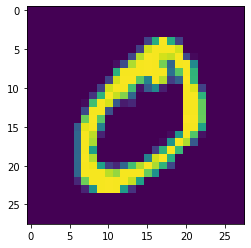

In [181]:
#이미지 확인
test_img = tf.squeeze(x_train[1]) # 28x28 , 실제 이미지 파일처럼 w*h 크기로 준비
plt.imshow(test_img)

In [182]:
#이미지를 array로 변경
#img에 img path가 들어가도 됨

def get_img_array(img):
  array = tf.keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis=0) # 1*28*28*1
  return array 


# img_array=get_img_array(x_train[0])

In [183]:
#Grad-CAM hitmap
def make_gradcam_heatmap(img_array,model,last_conv_layer_name,pred_index=None):
  
  grad_model = tf.keras.models.Model(
      [model.inputs],[model.get_layer(last_conv_layer_name).output,model.output]
  )

  with tf.GradientTape() as tape:
    last_conv_layer_output,preds = grad_model(img_array)

    if pred_index is None:
      pred_index = tf.argmax(preds[0]) #모델이 예측한 값

    class_channel = preds[:,pred_index] 

  grads = tape.gradient(class_channel, last_conv_layer_output) #grads = 1*11*11*64 크기의 gradient tensor 
  #class channel에 대한 last_conv_layer의 gradients
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # 64 크기의 gradient tensor
  #global average pooling

  last_conv_layer_output = last_conv_layer_output[0] # 11*11*64 크기의 레이어
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] # pooled_grads[...,tf.newaxis] = 64*1 크기의 tensor
  #last_conv_layer와 가중치 곱, heatmap= 1*11*11*1 크기의 tensor
  heatmap = tf.squeeze(heatmap) # 11*11

  # 0과 1사이로 normalize, 양의 값만 시각화 하기 위함
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  
  #500*500으로 img resize
  heatmap = np.uint8(255 * heatmap)
  heatmap= cv2.resize(heatmap, (500,500))

  return heatmap

In [184]:
heatmap = make_gradcam_heatmap(get_img_array(x_train[1]),model,'last_conv_layer',pred_index=None)

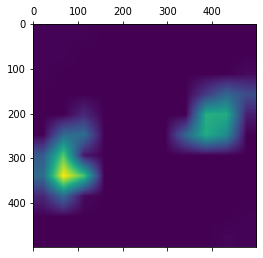

In [185]:
#시각화
plt.matshow(heatmap)
plt.show()

In [186]:
# 원본이미지랑 같이보기
SAVE_PATH="drive/MyDrive/Colab Notebooks/XAI/cam/cam_1.jpg"
IMG_SIZE=(500,500)

def save_display_gradcam(img, heatmap,img_size ,save_path,alpha=0.4):
  img = tf.squeeze(img)*255
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = cv2.resize(img, img_size)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)
  heatmap_resized = cv2.resize(heatmap, img_size)
  heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

  superimposed_img = heatmap_resized*alpha + img
  cv2.imwrite(save_path, superimposed_img)

In [187]:
save_display_gradcam(x_train[1], heatmap,img_size=IMG_SIZE, save_path=SAVE_PATH, alpha=0.8)

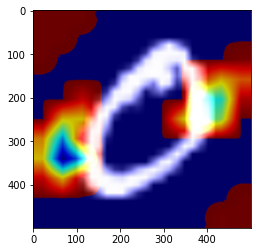

In [188]:
img = mpimg.imread(SAVE_PATH)
plt.imshow(img)

In [189]:
### keras grad-cam 공식 문서 참고
from IPython.display import Image, display

def save_and_display_gradcam(img, heatmap, cam_path="drive/MyDrive/Colab Notebooks/XAI/cam/cam_1.jpg", alpha=0.8):
    # Load the original image
    
    img = tf.squeeze(img)*255
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(x_train[1], heatmap)

In [190]:

for i,v in enumerate(test_ind):
  path = "drive/MyDrive/Colab Notebooks/XAI/cam/cam_{}.jpg".format(i)
  heatmap = make_gradcam_heatmap(get_img_array(x_train[v]),model,'last_conv_layer',pred_index=None)
  save_and_display_gradcam(x_train[v], heatmap, cam_path=path)